# Ensemble Learning

This notebook introduces the concept of ensemble learning. 

This technique aims at combining multiple learners to improve robutness and predictive performance.

We'll cover the main two approach of ensemble methods:

* Voting or averaging methods
* Boosting methods

The dataset we'll use consists of company data and we'll try to predict which ones will go bankrupt within a year.

In [0]:
# imports + data + preprocessing
!rm data.zip
!rm *arff
!curl "https://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip" -o "data.zip"
!unzip data.zip

In [0]:
!pip install numpy pandas scipy seaborn sklearn imblearn yellowbrick

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import arff
import seaborn as sn
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, \
  BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, cross_validate, \
  train_test_split, StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from yellowbrick.classifier import ConfusionMatrix


sn.set(rc={'figure.figsize': (10, 6)})


def evaluate_learner(learner, X, y, *args, **kwargs):
  kwargs.setdefault("cv", StratifiedKFold(5, random_state=0))
  kwargs.setdefault("return_train_score", True)
  res = pd.DataFrame(cross_validate(learner, X, y, *args, **kwargs))[[
      "train_score",
      "test_score"
  ]]
  res.plot.bar()
  return (100*res.agg(["mean", "std"])).applymap('{:,.2f}%'.format)


In [0]:
# Loading data
dataset = arff.loadarff("1year.arff")
np.random.seed(0)
np.random.shuffle(dataset[0])
df = pd.DataFrame(dataset[0])
df.fillna(df.median(), inplace=True)
df["class"] = df["class"].astype("int")

X = df.iloc[:, :-1].values
y = df["class"].values

Quick look at the data:

* we have 64 **features** and 7027 **samples**
* we see that we have a highly **imbalanced dataset**

In [0]:
X.shape

(7027, 64)

In [0]:
y.mean()

0.03856553294435748

Creating a function to resample the input dataset before training a model, this could be usefull

In [0]:
def resample_wrapper(learner):
  """
  Creates a classifier that resamples input values before training.
  
  Usefull for imbalanced datasets.
  """
  ros = RandomOverSampler(random_state=0)
  return Pipeline([
      ("ros", ros),
      ("learner", learner)
  ])

# Bootstrap aggregating (Bagging)


## Simple voting

Most intuitive way to combine multiple learners: train all of them and make them vote.

,train_score,test_score
mean,97.99%,96.95%
std,0.30%,0.60%


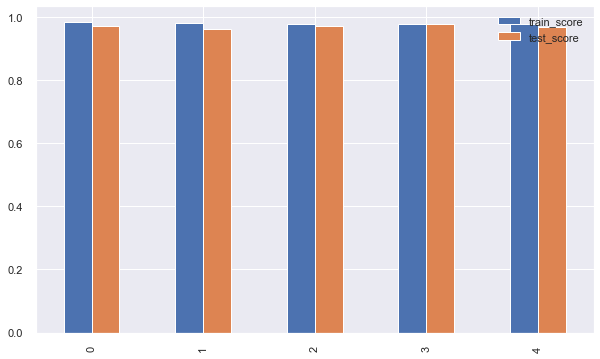

In [0]:
# Training baseline classifiers
tree = DecisionTreeClassifier(
    max_leaf_nodes=25,
    random_state=0
)

evaluate_learner(tree, X, y, cv=5)

Seems like we are performing well, but do not forget that the dataset is imbalanced. 

What can we do to verify if it is indeed performing well?

We'll look at the **confusion matrix**.

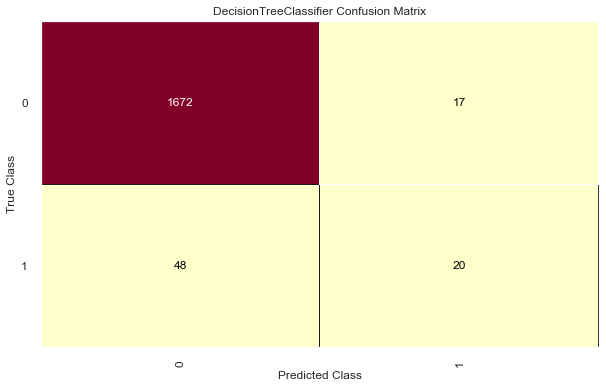

In [0]:
#sn.heatmap(confusion_matrix(tree.fit(X, y).predict(X), y), annot=True, fmt="d");
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

cm = ConfusionMatrix(tree)

cm.fit(X_train, y_train)

cm.score(X_test, y_test)
cm.poof()

To correct for this issue, we'll use **F1-score** instead of accuracy to measure the performance of our models. We'll also wrap our models with the `resample_wrapper` to oversample the bankrupcy examples.

For the following test we are choosing parameters that give a test score of 50% and see how we can have an impact on overfitting (difference between train and test set).

,train_score,test_score
mean,52.76%,35.64%
std,3.43%,5.23%


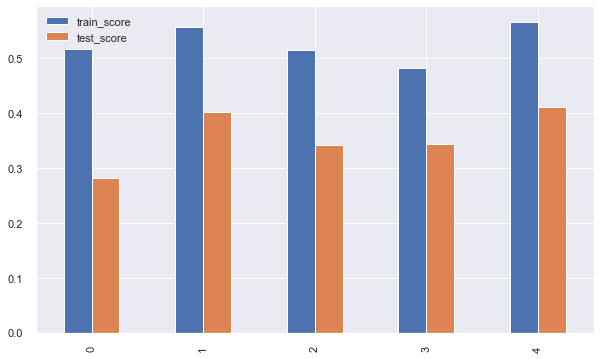

In [0]:
evaluate_learner(resample_wrapper(
    DecisionTreeClassifier(max_leaf_nodes=50, random_state=0)
), X, y, cv=5, scoring='f1')

The simple Decision Tree has a difference of 15% in F1-score between train and test.

Based on the Ragusa example, can reduce overfitting by taking multiple models and average them out?

,train_score,test_score
mean,52.76%,35.64%
std,3.43%,5.23%


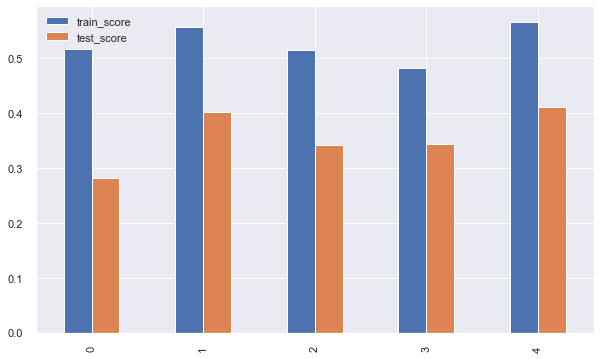

In [0]:
voting_clf = resample_wrapper(VotingClassifier([
    ('tree%d' % i, DecisionTreeClassifier(max_leaf_nodes=50, random_state=0)) for i in range(10)
], voting='soft', n_jobs=-1))

evaluate_learner(voting_clf, X, y, cv=5, scoring="f1")

It seems like nothing changed !!!

What's the roblem with this approach? 

Unfortunately, all trained learners use the same dataset. The end up in the same state after training and all the votes are the same... 


## Bagging

The first technique we will see to avoid this problem is called bootstrap aggregating or bagging. The idea is to give different samples from the dataset to each learner in the ensemble. With this approach, we'll get different votes for each underlying learner and reduce overall variance / improve generalization.

,train_score,test_score
mean,48.10%,34.59%
std,3.00%,3.21%


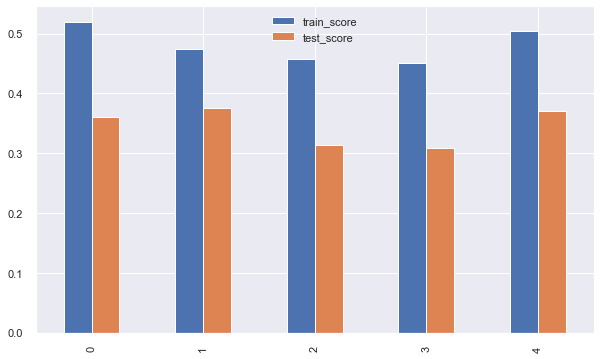

In [0]:
bagging_clf = resample_wrapper(BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=25, random_state=0), 
    n_estimators=50,
    n_jobs=-1,
    random_state=0
))

evaluate_learner(bagging_clf, X, y, cv=5, scoring="f1")

## Random forests


,train_score,test_score
mean,45.94%,34.82%
std,1.47%,1.61%


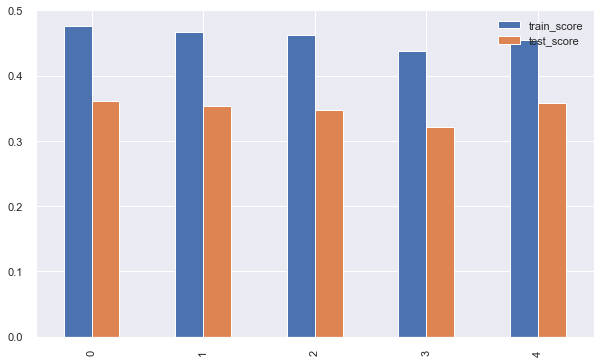

In [0]:
rand_forest = resample_wrapper(
    RandomForestClassifier(
        n_estimators=200, 
        max_features=32, 
        max_leaf_nodes=21, 
        n_jobs=-1,
        random_state=0
    )
)

evaluate_learner(rand_forest, X, y, cv=5, scoring="f1")

# Boosting

More advanced way to combine weak learners into a strong learner.

Construct that allows machine learning models that are slightly better than random guess to converge to a strong classifier.

In the following example, we'll try to give the intuition on how it works with a simple model that behaves like a sinusoid:

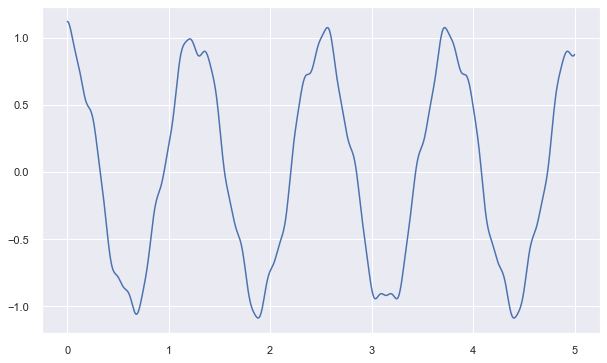

In [0]:
# Nested sinusoid
x = np.linspace(0, 5, 1000)
y1 = np.cos(x*5)
y2 = np.cos(x*22)/10
y3 = np.cos(x*51)/50
signal = y1 + y2 + y3

plt.plot(x, signal);

If we try to fit the plot above with a model that is the cosine function (considered as a weak learner), the best we can achieve at first is the red line

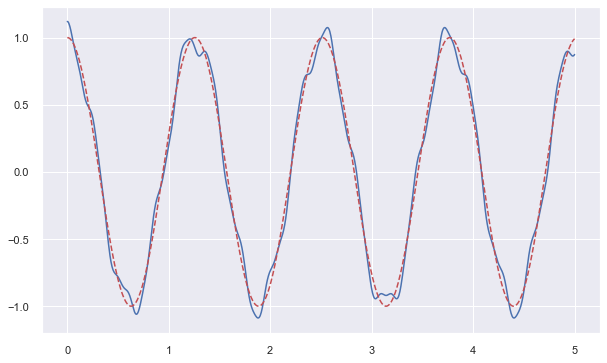

In [0]:
plt.plot(x, signal);
plt.plot(x, y1, color='r', linestyle="dashed");

In the context of boosting, we will chain a new learner of the same type (cosine) and pass it the errors of the first learner.

We therefore take the difference between the prediction of the first learner (red) and the actual value (blue) and train a new learner on this difference.

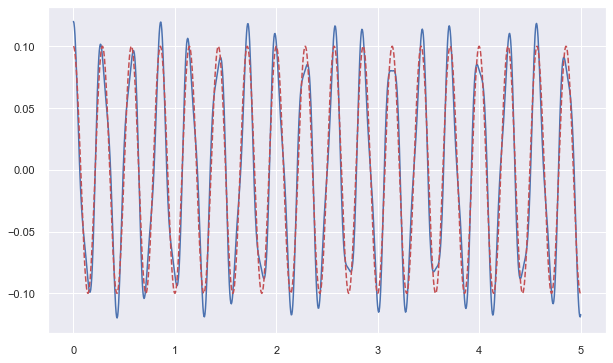

In [0]:
plt.plot(x, signal - y1);
plt.plot(x, y2, color='r', linestyle="dashed");

Once, fit we combine both learners to give a new prediction:

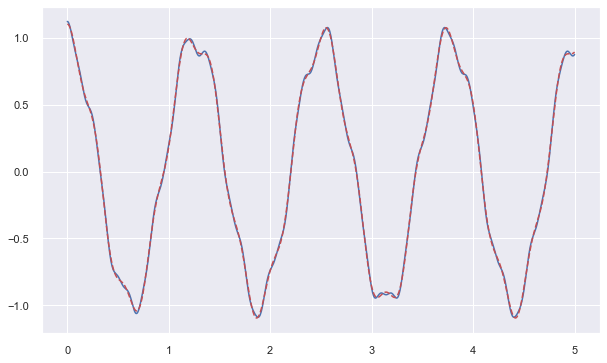

In [0]:
plt.plot(x, signal);
plt.plot(x, y1 + y2, color='r', linestyle="dashed");

## Weak learner

A common example of a weak learner is a small decision tree. Here is a quick reminder of a decision tree discussed in first section

,train_score,test_score
mean,19.40%,18.66%
std,0.77%,1.80%


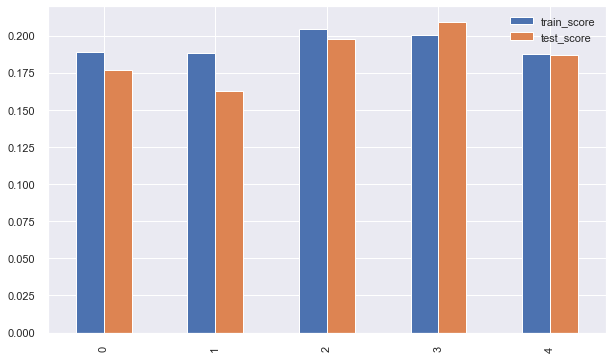

In [0]:
evaluate_learner(resample_wrapper(
    DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
), X, y, cv=5, scoring='f1')

## Gradient boosting

Train model on pseudo-residuals. Pseudo-residuals is based on the predictions of the current classifier and gives the "correction" we should apply to a given prediction to reduce the loss function.

,train_score,test_score
mean,42.19%,35.51%
std,2.05%,2.46%


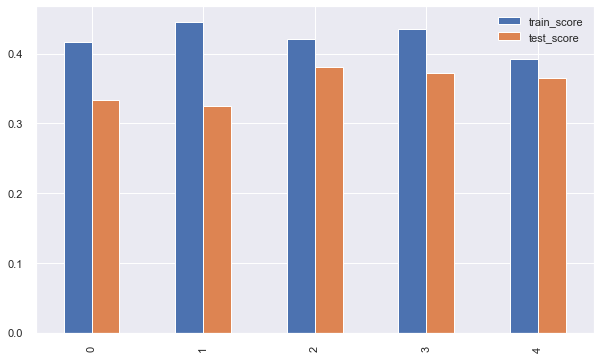

In [0]:
grad_boost = resample_wrapper(GradientBoostingClassifier(
    n_estimators=65,
    max_leaf_nodes=5,
    max_features=32,
    learning_rate=0.09,
    random_state=0
))

evaluate_learner(grad_boost, X, y, cv=5, scoring="f1", n_jobs=-1)

And it is better than a random forest classifier with similar test_score (lower difference with train score).

,train_score,test_score
mean,45.94%,34.82%
std,1.47%,1.61%


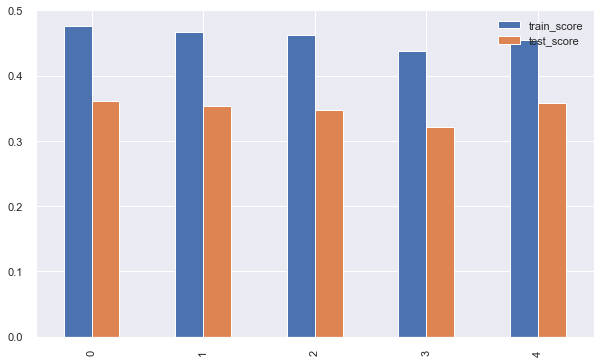

In [0]:
rand_forest = resample_wrapper(
    RandomForestClassifier(
        n_estimators=200, 
        max_features=32, 
        max_leaf_nodes=21, 
        n_jobs=-1,
        random_state=0
    )
)

evaluate_learner(rand_forest, X, y, cv=5, scoring="f1")

# Appendix

## Avoid overfitting

In [0]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
from yellowbrick.model_selection import ValidationCurve


def validation_curve_plot(learner, X, y, param_name, param_range):

  curve = ValidationCurve(
      learner, 
      param_name=param_name, 
      param_range=param_range,
      cv=5, scoring="f1", n_jobs=-1
  )
  curve.fit(X, y)
  curve.poof()

### Decision tree

We decide play with the parameter "max_leaf_nodes" and limit the number of leaves in our tree. From the graph below, we choose 12 as it is when it start to diverge between train and validation scores

In [0]:
# Simple decision tree
validation_curve_plot(
    resample_wrapper(
      DecisionTreeClassifier(random_state=0)
  ), X, y, "learner__max_leaf_nodes", np.arange(5, 100, 20)
)


### Bagging

In [0]:
validation_curve_plot(resample_wrapper(BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=12, random_state=0), 
    n_estimators=50,
    n_jobs=-1,
    random_state=0
)), X, y, "learner__base_estimator__max_leaf_nodes", np.arange(15, 35, 7))

### RandomForest

In [0]:
validation_curve_plot(resample_wrapper(
    RandomForestClassifier(
        n_estimators=200, 
        max_features=32, 
        max_leaf_nodes=12, 
        n_jobs=-1
    )
), X, y, "learner__max_leaf_nodes", np.arange(6, 33, 6))

In [0]:
validation_curve_plot(resample_wrapper(GradientBoostingClassifier(
    n_estimators=40,
    max_leaf_nodes=5,
    max_features=32,
    learning_rate=0.09
)), X, y, "learner__n_estimators", np.arange(30, 81, 10))